In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns
import tensorflow as tf
# import tensorflow_addons as tfa

from keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from tensorflow.keras.applications import ResNet50V2, VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array

In [ ]:
folder = '/content/drive/MyDrive/BreaKHis_v1/histology_slides/breast'
folder_path = pathlib.Path(folder)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=700x460 at 0x7F77A2AA6FE0>


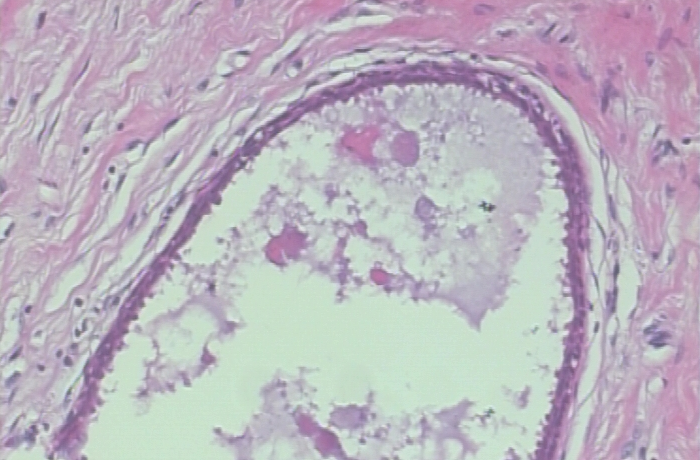

In [ ]:
photo = load_img('/content/drive/MyDrive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png')
print(photo)
photo

In [ ]:
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [ ]:
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM,
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 7919 images belonging to 2 classes.


In [ ]:
train_data, train_labels = train_data_gen.next()

In [ ]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(8040, 49152) (8040, 1)


In [ ]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(8040, 128, 128, 3) (8040, 1)


In [ ]:
train_labels = train_labels.reshape(-1, 1)

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


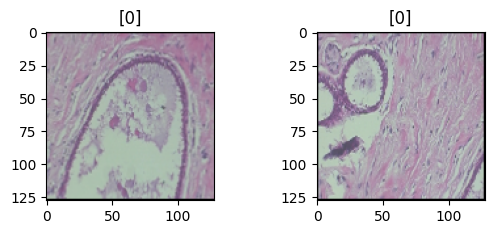

In [ ]:
for i in range(2):
    plt.subplot(2,2,1+i)
    plt.title(train_labels[i])
    plt.imshow(train_data[i])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
resnet50v2 = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze the layers in the pre-trained model
for layer in resnet50v2.layers:
    layer.trainable = False

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
ResNet50V2_model = Sequential([
    resnet50v2,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name="ResNet50V2_model")

In [ ]:
ResNet50V2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ResNet50V2_model.summary()

Model: "ResNet50V2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                  

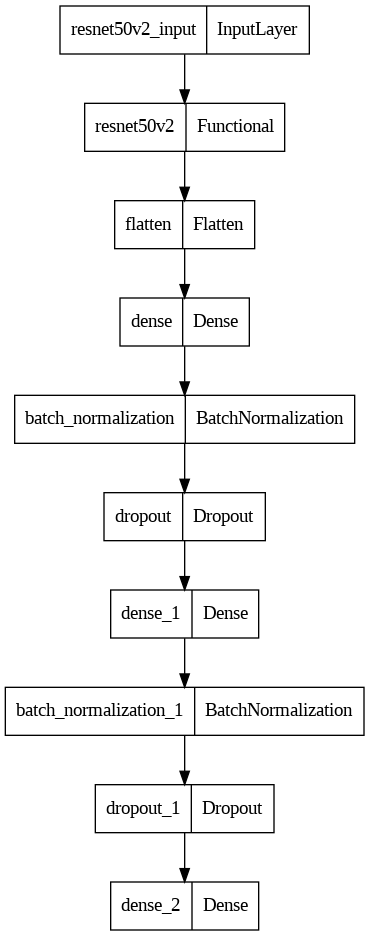

In [ ]:
plot_model(ResNet50V2_model)

In [ ]:
ResNet50V2_model_history = ResNet50V2_model.fit(train_data, train_labels, epochs=20, verbose=1)

# Store accuracy and loss history for each epoch
ResNet_accuracy_history = ResNet50V2_model_history.history['accuracy']
ResNet_loss_history = ResNet50V2_model_history.history['loss']

Epoch 1/20
161/161 [==============================] - 328s 2s/step - loss: 0.0451 - accuracy: 0.9839
Epoch 2/20
161/161 [==============================] - 325s 2s/step - loss: 0.0390 - accuracy: 0.9870
Epoch 3/20
161/161 [==============================] - 329s 2s/step - loss: 0.0451 - accuracy: 0.9846
Epoch 4/20
161/161 [==============================] - 325s 2s/step - loss: 0.0406 - accuracy: 0.9827
Epoch 5/20
161/161 [==============================] - 329s 2s/step - loss: 0.0321 - accuracy: 0.9885
Epoch 6/20
161/161 [==============================] - 328s 2s/step - loss: 0.0251 - accuracy: 0.9918
Epoch 7/20
161/161 [==============================] - 326s 2s/step - loss: 0.0307 - accuracy: 0.9885
Epoch 8/20
161/161 [==============================] - 332s 2s/step - loss: 0.0398 - accuracy: 0.9860
Epoch 9/20
161/161 [==============================] - 326s 2s/step - loss: 0.0392 - accuracy: 0.9864
Epoch 10/20
161/161 [==============================] - 331s 2s/step - loss: 0.0366 - accura

In [ ]:
loss, accuracy = ResNet50V2_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

51/51 [==============================] - 93s 2s/step - loss: 0.6260 - accuracy: 0.8650
Accuracy: 86.50%


In [ ]:
y_pred = np.round(ResNet50V2_model.predict(test_data)).astype(int)

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']

# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

ResNet_precision = avg_precision
ResNet_recall = avg_recall
ResNet_f1score = avg_f1_score

51/51 [==============================] - 92s 2s/step
Average Precision: 86.51%
Average Recall: 86.50%
Average F1 Score: 86.50%


In [ ]:
y_scores = ResNet50V2_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()